In [18]:
%matplotlib inline

In [19]:
import matplotlib.pyplot as plt
import json

In [20]:
with open('../test-out.txt', 'r') as f:
    raw_data = f.read()

## Clean Raw Data

In [29]:
import re
from collections import defaultdict

lines = [*filter(None, map(str.strip, raw_data.splitlines()))]
gas_uses = defaultdict(lambda: {
    'gas_used': [],
    'byte_count': []
})
i = 0
while i < len(lines):
    if lines[i] == 'Logs:':
        name = re.search(r'test_(\w+)\(\)', lines[i-1]).group(1)
        print(name)
        i += 1
        while (m := re.match(r'(\d+): (\d+)', lines[i])): 
            byte_count = int(m.group(1))
            gas_used = int(m.group(2))
            
            gas_uses[name]['byte_count'].append(byte_count)
            gas_uses[name]['gas_used'].append(gas_used)
            i += 1
    else:
        i += 1
    
gas_uses

SSTORE2
SSTORE3_L
SSTORE3_S


## Add Storage Warming Costs (and calculate hypothetical SSTORE3_M)

In [30]:
 sstore3s = gas_uses['SSTORE3_S']
sstore3m = gas_uses['SSTORE3_M']

for i, (bc, gas) in enumerate(zip(sstore3s['byte_count'], sstore3s['gas_used'])):
    # Uses 1 base slot for length + first 30 bytes, new slot for every 32 bytes after that
    slots = bc // 32 + 1 + (bc % 32 == 31)
    sstore3s['gas_used'][i] += 2000 * slots
    sstore3m['byte_count'].append(bc)
    sstore3m['gas_used'].append(gas - 120 * slots)

## Save Data

In [32]:
with open('../gas-use.json', 'w') as f:
    json.dump(gas_uses, f)

## Plot Data

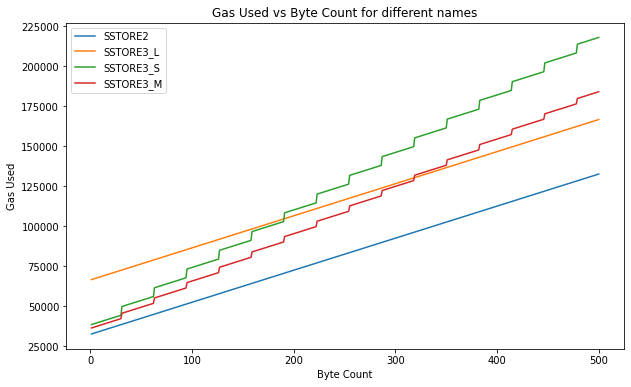

In [44]:
plt.figure(figsize=(10, 6))

cap = 500

# loop through the names in the data
for name in gas_uses:
    x = gas_uses[name]["byte_count"][:cap]
    y = gas_uses[name]["gas_used"][:cap]
    plt.plot(x, y, label=name)

plt.xlabel("Byte Count")
plt.ylabel("Gas Used")
plt.title("Gas Used vs Bytes Stored")
plt.legend()

In [42]:
last_order = (None, None, None, None)
for i in range(24575):
    order = tuple(
        sorted(
            gas_uses.keys(),
            key=lambda l: gas_uses[l]['gas_used'][i] 
        )
    )
    if order != last_order:
        bc = gas_uses[order[0]]['byte_count'][i]
        print(f'{bc}: {order}')
        last_order = order

1: ('SSTORE2', 'SSTORE3_M', 'SSTORE3_S', 'SSTORE3_L')
191: ('SSTORE2', 'SSTORE3_M', 'SSTORE3_L', 'SSTORE3_S')
319: ('SSTORE2', 'SSTORE3_L', 'SSTORE3_M', 'SSTORE3_S')
